"""
This file preprocesses plankton data by combining environmental measurements from a master table with morphological 
features from individual CSV files. It filters for specific zooplankton classes (including Calanoid, Cyclopoid, 
Bosmina, etc.), merges relevant physical measurements (such as area, circularity, and diameter) with environmental 
variables (water temperature, depth, precipitation), and performs initial exploratory data analysis through 
statistical summaries and visualizations. The processed data is saved as a merged dataset for further analysis.

The processed data is not saved on Github, but is saved in the folder "plankton_data/plankton_data_csv"
"""

## Import neccessary classes

In [1]:
import sys
print("Python path:", sys.executable)

Python path: /Users/willwu/Documents/GitHub/Zooplankton/plankton_env/bin/python


In [2]:
### Import the Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


## Data Preprocessing

In [3]:

# Load the Master Table
master_table = pd.read_excel("/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/MasterTable_AI_FlowCAM.xlsx")

# Display column names
print(master_table.columns)

# Check for constant or mostly empty columns
constant_columns = [col for col in master_table.columns if master_table[col].nunique() <= 1]
print("Constant Columns:", constant_columns)


Index(['tifffile', 'csvfile', 'Year', 'SAM', 'Month', 'Day', 'Rep', 'repnum',
       'Key', 'Loc', 'SITE', 'DOY', 'gdd2', 'WaterT', 'LAT0', 'LAT1', 'LON0',
       'LON1', 'avgdepth', 'trawltime', 'EFFSPEED', 'MinDepth', 'MaxDepth',
       'XANGLE', 'PRECIP', 'XWAVEHT', 'WIND', 'CLOUD_PC', 'distshore', 'FR',
       'volbest', 'WhitefishDen', 'UnknwCoregonine', 'CiscoDen', 'Exposure',
       'SmeltDen', 'YPerchDen', 'BurbotDen', 'OtherFishDen'],
      dtype='object')
Constant Columns: []


In [4]:

# Drop unnecessary columns
columns_to_drop = ["Key", "Rep", "trawltime", "EFFSPEED", "volbest", "FR"]
master_table = master_table.drop(columns=columns_to_drop, errors='ignore')

# Create the AvgDepth column and remove MinDepth and MaxDepth columns
if "MinDepth" in master_table.columns and "MaxDepth" in master_table.columns:
    master_table["AvgDepth"] = master_table[["MinDepth", "MaxDepth"]].mean(axis=1)
    master_table = master_table.drop(columns=["MinDepth", "MaxDepth"], errors='ignore')

In [5]:
#print the column names of the master_table
print("Current columns in master_table:")
print(master_table.columns)

Current columns in master_table:
Index(['tifffile', 'csvfile', 'Year', 'SAM', 'Month', 'Day', 'repnum', 'Loc',
       'SITE', 'DOY', 'gdd2', 'WaterT', 'LAT0', 'LAT1', 'LON0', 'LON1',
       'avgdepth', 'XANGLE', 'PRECIP', 'XWAVEHT', 'WIND', 'CLOUD_PC',
       'distshore', 'WhitefishDen', 'UnknwCoregonine', 'CiscoDen', 'Exposure',
       'SmeltDen', 'YPerchDen', 'BurbotDen', 'OtherFishDen', 'AvgDepth'],
      dtype='object')


### Files Management for Data Merging

In [6]:
# Extract relevant CSV file names from the master file
csv_file_names = master_table["csvfile"].dropna().unique()

# Convert the file names to a set for quick lookup
csv_file_set = set(csv_file_names)

# Print the extracted file names (optional, for verification)
print(f"Extracted {len(csv_file_set)} file names from the master table.")


Extracted 478 file names from the master table.


In [10]:
# Define the output folder
output_folder = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"Output folder created at: {output_folder}")


Output folder created at: /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv


#### Storing Files only to Target Class

In [11]:
useful_columns = [
    "Class",
    "Area..ABD.",           # Matches "Area"
    "Aspect.Ratio",         # Matches "Aspect Ratio"
    "Circularity",          # Matches "Circularity"
    "Compactness",          # Matches "Compactness"
    "Convexity",            # Matches "Convexity"
    "Elongation",           # Matches "Elongation"
    "Diameter..ABD.",       # Matches "Diameter (ABD)"
    "Diameter..ESD.",       # Matches "Diameter (ESD)"
    "Perimeter",            # Matches "Perimeter"
    "Intensity",            # Matches "Intensity"
    "Sigma.Intensity",      # Matches "Sigma Intensity"
    "Roughness",            # Matches "Roughness"
    "Transparency",         # Matches "Transparency
    "Image.File",           # Matches "Image File"
    "Particle.ID",          # Matches "Particle ID"
    "Image.Height",
    "Image.Width",
    "Image.X",
    "Image.Y"
]

# Target zooplankton classes
target_classes = {"Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"}

# Initialize a list to store names of files not found in the master table
files_not_in_master = []

# Define paths to the input folders
input_folders = ["/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/HURONOvlerap_csv", "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/SIMC.Overlap.csv"]

# Process each CSV file in the input folders
for folder in input_folders:
    for file_name in os.listdir(folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder, file_name)

            # Check if the file is in the master table
            if file_name in csv_file_set:
                try:
                    # Load the CSV file
                    data = pd.read_csv(file_path)

                    # Filter for useful columns only
                    filtered_data = data[[col for col in useful_columns if col in data.columns]]

                    # Filter rows where "Class" belongs to target classes
                    if "Class" in filtered_data.columns:
                        filtered_data = filtered_data[filtered_data["Class"].isin(target_classes)]
                    
                    # Add a new column for filename
                    filtered_data["Filename"] = file_name

                    # Save the filtered data to the new folder
                    output_path = os.path.join(output_folder, file_name)
                    filtered_data.to_csv(output_path, index=False)
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
            else:
                # Store the file name if not in the master table
                files_not_in_master.append(file_name)

print(f"Processing complete. {len(files_not_in_master)} files were not in the master table.")
# print the number of rows per classes for all the files in the ouput folder



Processing complete. 103 files were not in the master table.


#### Storing Files to all Class  (Optional)

In [9]:
# Define the output folder
output_folder = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv_all"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print(f"Output folder created at: {output_folder}")


import os
import pandas as pd
from collections import defaultdict

# Useful columns to keep
useful_columns = [
    "Class", "Area..ABD.", "Aspect.Ratio", "Circularity", "Compactness",
    "Convexity", "Elongation", "Diameter..ABD.", "Diameter..ESD.",
    "Perimeter", "Intensity", "Sigma.Intensity", "Roughness", "Transparency",
    "Image.File", "Particle.ID", "Image.Height", "Image.Width", "Image.X", "Image.Y"
]

# Class limit
max_rows_per_class = 100000

# Keep track of how many rows per class have been saved
class_counts = defaultdict(int)

# Folders
input_folders = [
    "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/HURONOvlerap_csv",
    "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/SIMC.Overlap.csv"
]

# List of files not found in the master table
files_not_in_master = []

for folder in input_folders:
    for file_name in os.listdir(folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder, file_name)

            if file_name in csv_file_set:
                try:
                    data = pd.read_csv(file_path)

                    # Filter for useful columns
                    filtered_data = data[[col for col in useful_columns if col in data.columns]]

                    if "Class" in filtered_data.columns:
                        # Add filename column
                        filtered_data["Filename"] = file_name

                        # Group by class and enforce row limits
                        filtered_subset = []

                        for class_name, group in filtered_data.groupby("Class"):
                            remaining = max_rows_per_class - class_counts[class_name]
                            if remaining > 0:
                                selected_rows = group.head(remaining)
                                class_counts[class_name] += len(selected_rows)
                                filtered_subset.append(selected_rows)

                        if filtered_subset:
                            final_df = pd.concat(filtered_subset, ignore_index=True)
                            output_path = os.path.join(output_folder, file_name)
                            final_df.to_csv(output_path, index=False)

                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
            else:
                files_not_in_master.append(file_name)

print(f"Processing complete. {len(files_not_in_master)} files were not in the master table.")
print("Rows saved per class:")
for k, v in class_counts.items():
    print(f"{k}: {v}")


Output folder created at: /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Filename"] = file_name
/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Filename"] = file_name
/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Processing complete. 103 files were not in the master table.
Rows saved per class:
Bubbles: 5440
Calanoid_1: 248390
CopepodSpp: 9721
CountGT500: 14691
Cyclopoid_1: 197893
Floc_1: 300000
Herpacticoida: 1739
LargeZ-1: 81325
Nauplii: 2209
TooSmall: 300000
Unknown: 1265
Bosmina_1: 7225
Chironomid: 1540
Nematode: 30
Eggs: 103
Naididae: 36
InsectLarvae: 164
Chydoridae: 107
CladoceraSpp: 883
Sididae: 477
Rotifer: 8
Daphnia: 560
Holopedidae: 84
Insecta: 57
Polyphemidae: 3
Leptodoridae: 1
Floc_2: 101
Trombidiforme: 1
Holopididae: 12
Cercopagididae: 5
Cyclo_2: 19881
Holopediidae: 5


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Filename"] = file_name
/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Filename"] = file_name
/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/3214914434.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

###

In [12]:
# Define the final output file path
final_output_path = os.path.join(output_folder, "combined_data.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Read and concatenate all modified CSV files
for file_name in os.listdir(output_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(output_folder, file_name)
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")

# Combine all DataFrames into one
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Save the combined dataset
    combined_df.to_csv(final_output_path, index=False)
    
    print(f"Successfully combined {len(dfs)} CSV files into {final_output_path}")
else:
    print("No CSV files found to combine.")


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/4130396607.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


Successfully combined 474 CSV files into /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv/combined_data.csv


In [15]:

# Load the combined large CSV file !!!!!! Update the path if needed !!!!!!
large_csv_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/plankton_data_csv/combined_data.csv"  # Update if needed
large_csv = pd.read_csv(large_csv_path)

# Ensure filename column is present in the large CSV
if "Filename" not in large_csv.columns:
    raise ValueError("The 'Filename' column is missing in the large CSV file.")

# Merge the master table with the large CSV on 'csvfile' (from master) and 'Filename' (from large CSV)
merged_df = master_table.merge(large_csv, left_on="csvfile", right_on="Filename", how="inner")
#remove duplicates in the merged dataframe
merged_df = merged_df.drop_duplicates(subset=["Particle.ID", "Filename"])

# Save the merged dataset
merged_output_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_Subset_2.csv"
merged_df.to_csv(merged_output_path, index=False)

print(f"Merging complete. Merged dataset saved at: {merged_output_path}")


Merging complete. Merged dataset saved at: /Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_Subset_2.csv


## Data Analysis

In [16]:
filtered_data_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_Subset_2.csv"  # Replace with actual path
merged_df = pd.read_csv(filtered_data_path)

target_classes = {"Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"}

# Drop "TooSmall" and na classes
merged_df = merged_df[merged_df["Class"] != "TooSmall"]
merged_df = merged_df.dropna(subset=["Class"])

# Compute class counts
class_counts = merged_df["Class"].value_counts()

# Create a function to rename classes
def reassign_class(row):
    class_name = row["Class"]
    if class_name in target_classes:
        return class_name
    elif class_counts[class_name] < 2500:
        return "other"
    else:
        return class_name  # keep other large-volume classes as-is

# Apply the class reassignment
merged_df["Class"] = merged_df.apply(reassign_class, axis=1)

# Check new class distribution
print(merged_df["Class"].value_counts())



# Leave blank for potentially saving as a csv


Class
Calanoid_1       248390
Cyclopoid_1      197893
Bosmina_1          7225
Herpacticoida      1739
Chironomid         1540
Daphnia             560
Chydoridae          107
Name: count, dtype: int64


In [ ]:
# Summary statistics for numerical columns

selected_columns = [
    "WaterT", "AvgDepth", "PRECIP", "gdd2", "DOY", "SmeltDen", "YPerchDen", "BurbotDen", "OtherFishDen", 
    "distshore", "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Generate summary statistics for the selected variables
summary_stats = merged_df[selected_columns].describe()

# Display the summary statistics directly
print("\nSummary Statistics of Selected Variables:")
print(summary_stats)

# Optionally, you can also display it in a more readable format:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide tables
print(summary_stats)


Summary Statistics of Selected Variables:
              WaterT       AvgDepth         PRECIP           gdd2  \
count  457454.000000  457454.000000  457454.000000  457454.000000   
mean       11.713817      12.696817       3.303687     172.275305   
std         4.848562       8.563729      11.736461     132.382292   
min         3.500000       1.250000       0.000000      11.720000   
25%         7.900000       5.250000       0.000000      59.229407   
50%        11.700000       9.500000       0.000000     140.374878   
75%        14.900000      20.100000       0.000000     277.312317   
max        22.600000      38.300000      61.000000     475.240880   

                 DOY      SmeltDen      YPerchDen      BurbotDen  \
count  457454.000000  59102.000000  457373.000000  457373.000000   
mean      137.772952      0.000006       0.025271       0.000031   
std        12.848320      0.000469       0.112201       0.000439   
min        97.000000      0.000000       0.000000       0.00000

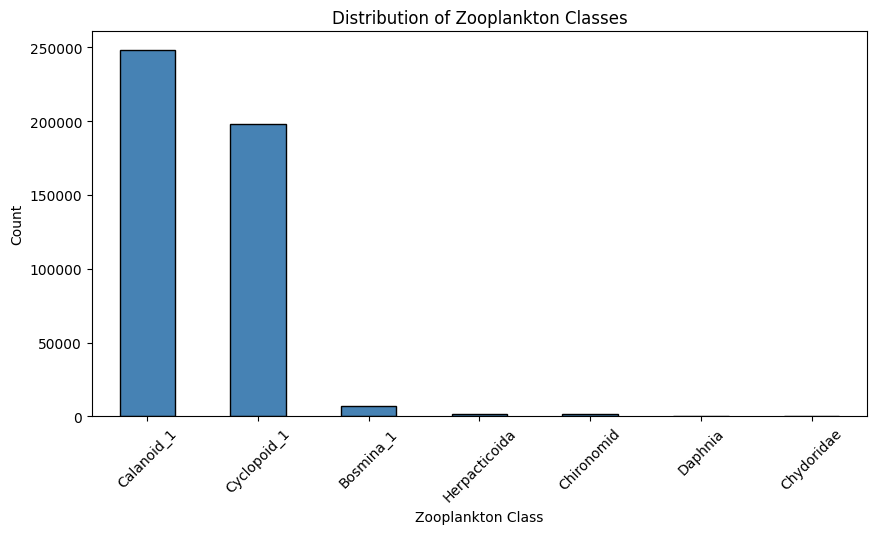

['Calanoid_1' 'Herpacticoida' 'Cyclopoid_1' 'Chironomid' 'Bosmina_1'
 'Chydoridae' 'Daphnia']
Class
Calanoid_1       248390
Cyclopoid_1      197893
Bosmina_1          7225
Herpacticoida      1739
Chironomid         1540
Daphnia             560
Chydoridae          107
Name: count, dtype: int64


In [19]:
import matplotlib.pyplot as plt

# Count the number of observations per species
plt.figure(figsize=(10, 5))
merged_df["Class"].value_counts().plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Distribution of Zooplankton Classes")
plt.xlabel("Zooplankton Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

print(merged_df["Class"].unique())

print(merged_df["Class"].value_counts())


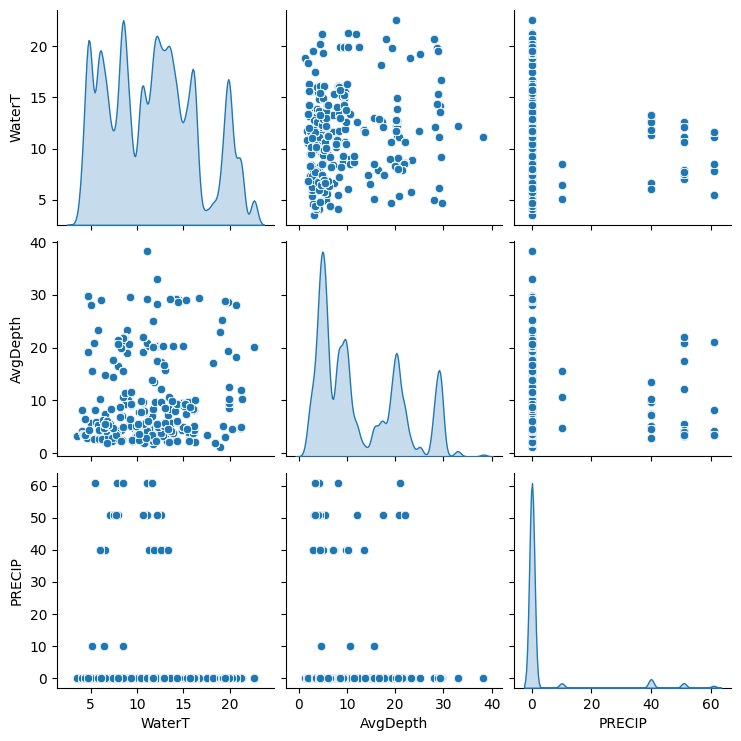

In [20]:
import seaborn as sns

# Pairplot for key environmental variables
env_features = ["WaterT", "AvgDepth", "PRECIP"]
sns.pairplot(merged_df[env_features].dropna(), diag_kind="kde")
plt.show()


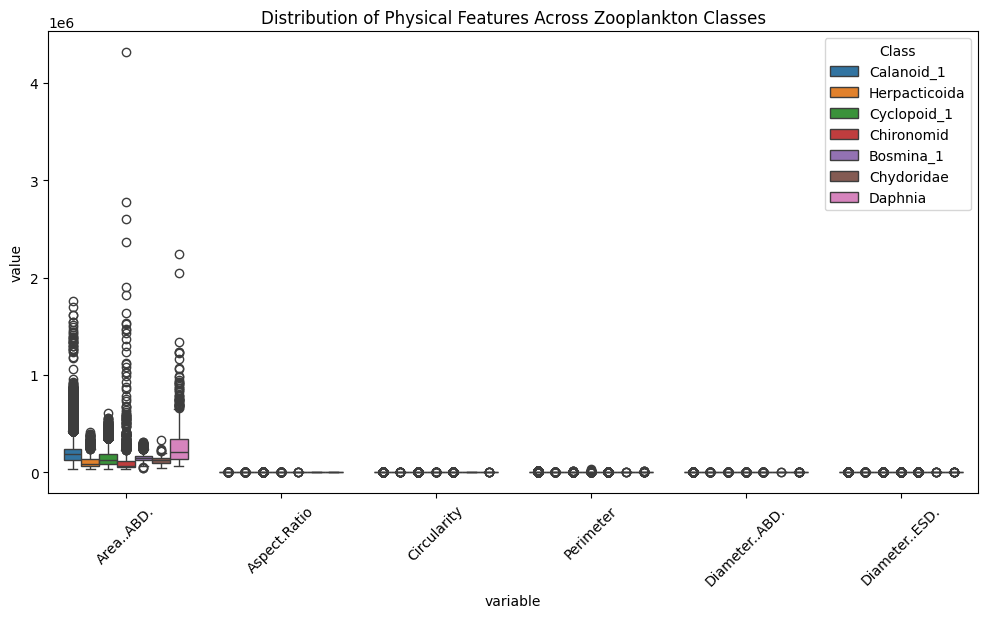

In [21]:
# Boxplot for physical measurements by species
physical_features = ["Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."]

plt.figure(figsize=(12, 6))
df_melted = merged_df.melt(id_vars=["Class"], value_vars=physical_features)
sns.boxplot(x="variable", y="value", hue="Class", data=df_melted)
plt.xticks(rotation=45)
plt.title("Distribution of Physical Features Across Zooplankton Classes")
plt.show()


/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


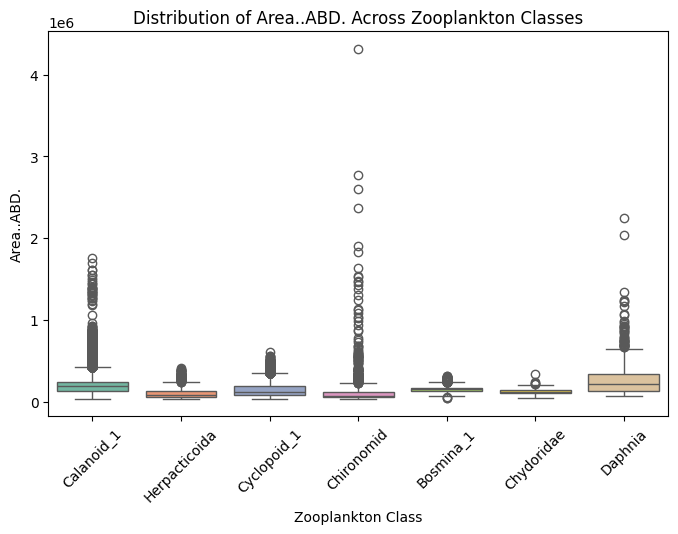

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


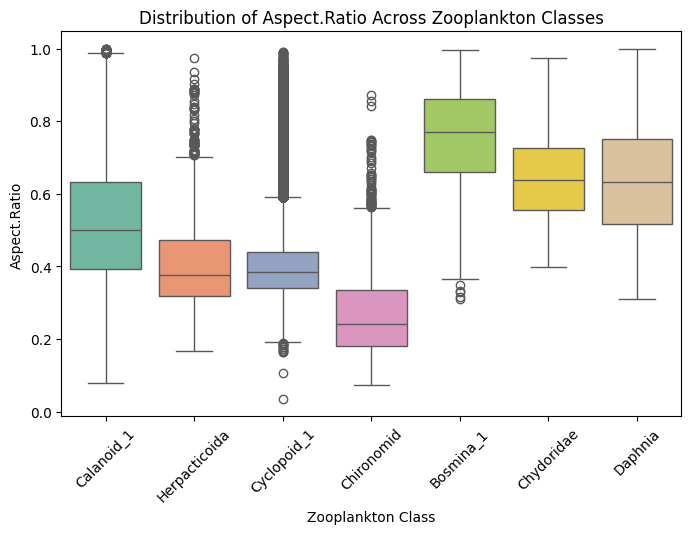

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


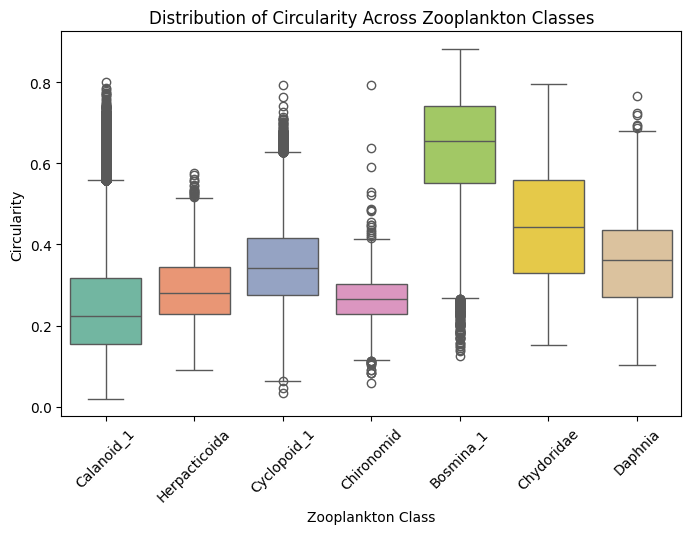

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


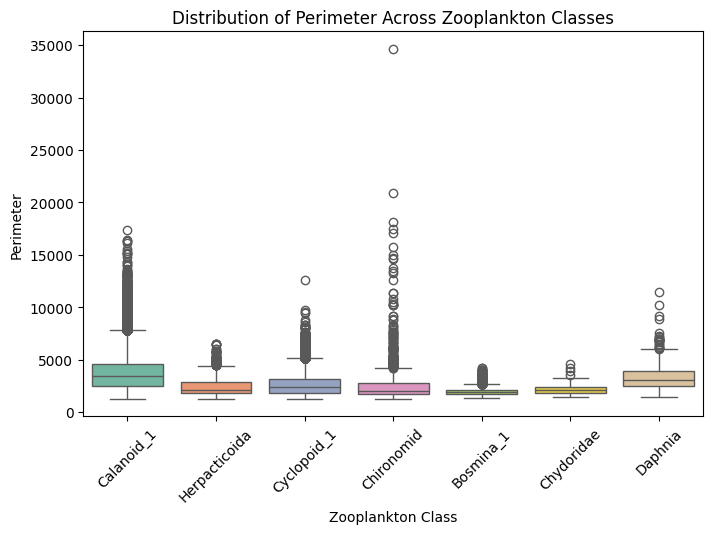

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


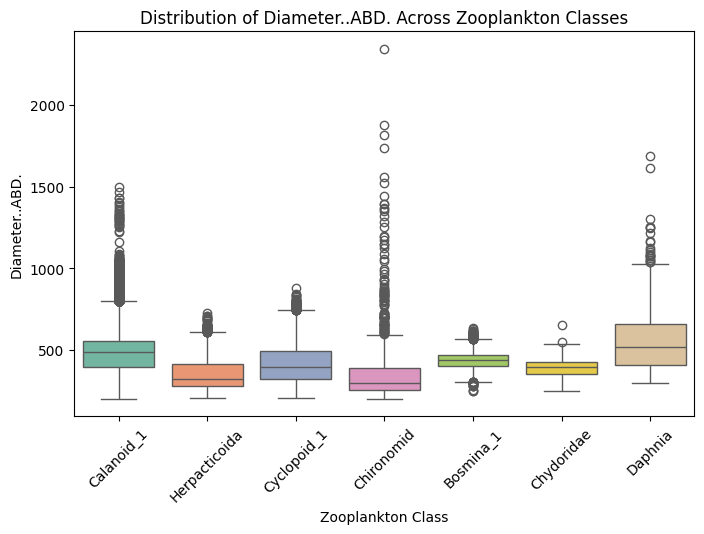

/var/folders/z1/m0zdhyss3_xcp1hpgzc17plh0000gn/T/ipykernel_61219/1192440060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")


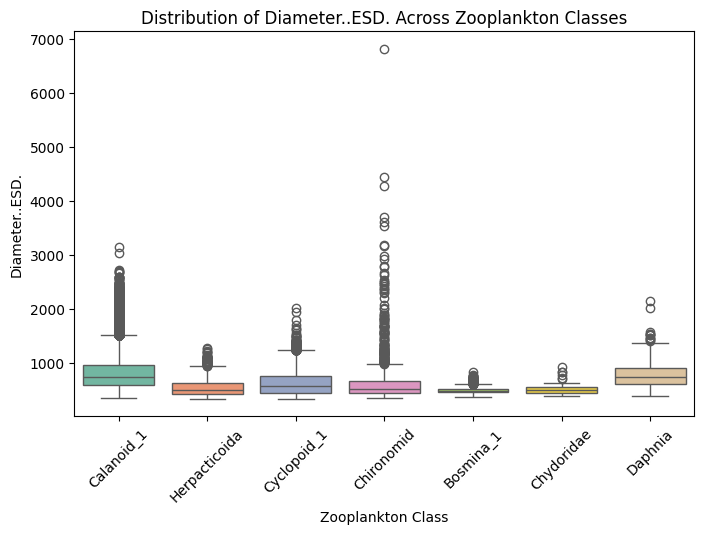

In [22]:
# List of physical features to plot separately
physical_features = [
    "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Create separate boxplots for each feature
for feature in physical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Class", y=feature, data=merged_df, palette="Set2")
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature} Across Zooplankton Classes")
    plt.xlabel("Zooplankton Class")
    plt.ylabel(feature)
    plt.show()

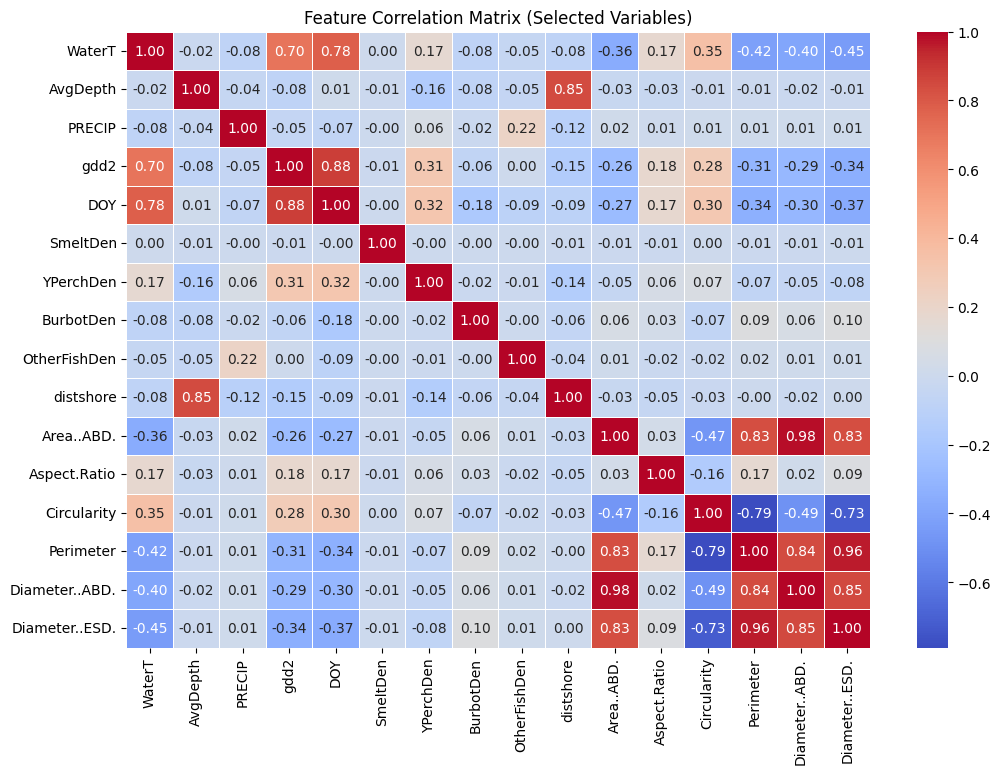

In [23]:

# Select only the relevant variables for correlation analysis
selected_columns = [
    "WaterT", "AvgDepth", "PRECIP", "gdd2", "DOY", "SmeltDen", "YPerchDen", "BurbotDen", "OtherFishDen", 
    "distshore", "Area..ABD.", "Aspect.Ratio", "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."
]

# Compute the correlation matrix
corr_matrix = merged_df[selected_columns].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (Selected Variables)")
plt.show()


### Below is for All Classes Use Only (Optional)

In [23]:
# Filter only rows with Class == 'Cyclo_2'
cyclo2_df = merged_df[merged_df["Class"] == "Cyclo_2"]

# Count missing values per column in Cyclo_2.
missing_per_column = cyclo2_df.isnull().sum().sort_values(ascending=False)

# Display the columns with missing values (sorted)
print("Missing values in Cyclo_2 subset:\n", missing_per_column)

# Drop columns in SmeltDen
merged_df = merged_df.drop(columns=["SmeltDen"], errors='ignore')



Missing values in Cyclo_2 subset:
 SmeltDen           19881
distshore           2947
CiscoDen             261
UnknwCoregonine      261
WhitefishDen         261
Exposure             170
Elongation             0
AvgDepth               0
Class                  0
Area..ABD.             0
Aspect.Ratio           0
Circularity            0
Compactness            0
Convexity              0
Diameter..ABD.         0
BurbotDen              0
Diameter..ESD.         0
Perimeter              0
Intensity              0
Sigma.Intensity        0
Roughness              0
Transparency           0
Image.File             0
Particle.ID            0
Image.Height           0
Image.Width            0
Image.X                0
Image.Y                0
OtherFishDen           0
tifffile               0
YPerchDen              0
WaterT                 0
Year                   0
SAM                    0
Month                  0
Day                    0
repnum                 0
Loc                    0
SITE           

Note that Cyclco_2 has missing values in columns "SmeltDen" across all Cyclo_2 observations.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Check missing values in the dataset
print("Missing Values per Column:\n", merged_df.isnull().sum())

# Print out the rows with missing values in these columns
missing_values = merged_df[merged_df.isnull().any(axis=1)]
print("Rows with Missing Values:\n", missing_values)

#filter out the rows with missing values
merged_df = merged_df.dropna()

merged_df["Class"].value_counts()

In [30]:
merged_output_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_All_Clean.csv"
merged_df.to_csv(merged_output_path, index=False)

In [12]:
merged_df = pd.read_csv("/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_all.csv")

In [ ]:
# Ensure WIND is a string type
merged_df["WIND"] = merged_df["WIND"].astype(str)

# Split WIND into direction and speed
wind_split = merged_df["WIND"].str.split("-", expand=True)

# Assign to new columns and convert to integers
merged_df["wind_direction"] = pd.to_numeric(wind_split[0], errors="coerce")
merged_df["wind_speed"] = pd.to_numeric(wind_split[1], errors="coerce")

# Drop the original WIND column if no longer needed
# merged_df.drop(columns=["WIND"], inplace=True)

# Preview result
merged_df[["WIND", "wind_direction", "wind_speed"]].head()


,WIND,wind_direction,wind_speed
0,090-05,90,5
1,090-05,90,5
2,090-05,90,5
3,090-05,90,5
4,090-05,90,5


In [14]:
merged_df.to_csv("/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_all.csv", index=False)

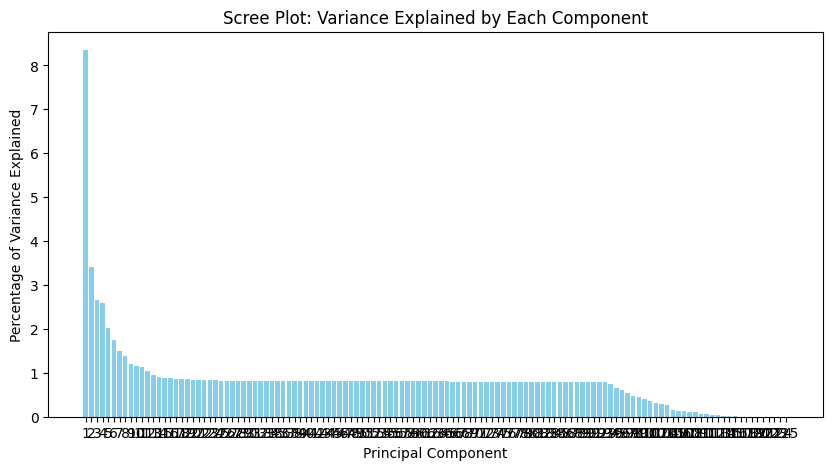

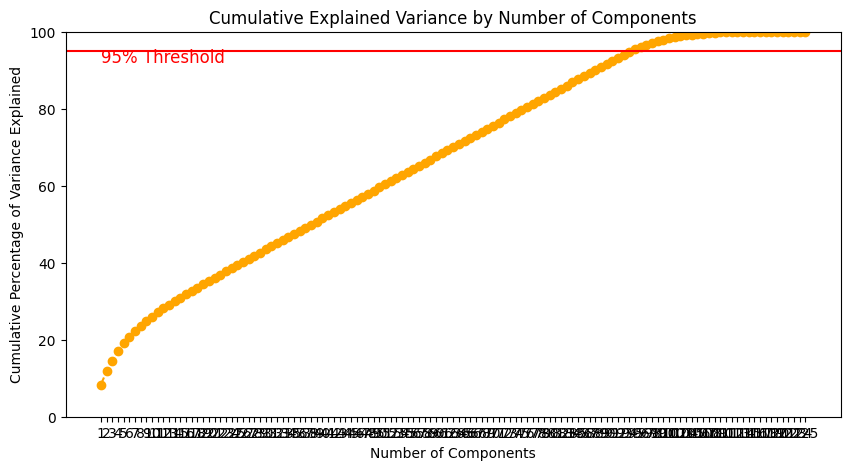

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming df is your DataFrame containing the selected features
features = ["WaterT", "AvgDepth", "PRECIP", "gdd2", "DOY", "YPerchDen", 
            "BurbotDen", "OtherFishDen", "distshore", "Area..ABD.", "Aspect.Ratio", 
            "Circularity", "Perimeter", "Diameter..ABD.", "Diameter..ESD."]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[features])

# Perform PCA without limiting the number of components to get full info
pca_full = PCA()
pca_full.fit(X_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot 1: Scree Plot for Individual Explained Variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Scree Plot: Variance Explained by Each Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# Plot 2: Cumulative Explained Variance Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linestyle='--', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percentage of Variance Explained')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axhline(y=95, color='red', linestyle='-')
plt.text(1, 92, '95% Threshold', color='red', fontsize=12)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.ylim(0, 100)
plt.show()


In [16]:
# read in data from Merged_Master_CSV.csv and print the total number of observations
df = pd.read_csv("/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_CSV.csv")
print("Total number of observations:", len(df))

: 

In [ ]:
# Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 300000

# Perform class-wise sampling
balanced_df = df.groupby("Class", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_CLASS), random_state=42)
)

# Save the balanced dataset to a new CSV file
merged_output_path = "/Users/willwu/Documents/GitHub/Zooplankton/plankton_data/Merged_Master_Subset.csv"
balanced_df.to_csv(merged_output_path, index=False)

print(f"Balanced dataset saved to: {merged_output_path}")
print("Class distribution after sampling:")
print(balanced_df["Class"].value_counts())

